# Dog Image classification using resnet18

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 4.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 18.4 MB/s eta 0:00:00


In [7]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import smdebug

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip 

In [8]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

In [9]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "Dog-Images-Set"
role = sagemaker.get_execution_role()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [10]:
#TODO: Declare your HP ranges, metrics etc.
inputs = "s3://sagemaker-us-east-1-706723451900/dogImages"

#ref: Exercise: Hyperparameter Tuning in SageMaker


hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16,32]),
    "epochs": IntegerParameter(2,4)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [11]:
#TODO: Create estimators for your HPs

from sagemaker.pytorch import PyTorch

# TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    objective_type=objective_type,
    base_tuning_job_name = 'tuning-job'
)



In [27]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs}, wait=True)
# TODO: Remember to include your data channels

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: tuning-job-230316-0616


......................................................................................................................................................................................................................................................................................................................................................................................................................!


In [15]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-03-15 14:29:34 Starting - Found matching resource for reuse
2023-03-15 14:29:34 Downloading - Downloading input data
2023-03-15 14:29:34 Training - Training image download completed. Training in progress.
2023-03-15 14:29:34 Uploading - Uploading generated training model
2023-03-15 14:29:34 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'epochs': '4',
 'lr': '0.03305079691259119',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-15-13-37-17-692"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-706723451900/pytorch-training-2023-03-15-13-37-17-692/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [12]:
# TODO: Set up debugging and profiling rules and hooks

# ref: Exercise: Debugger and Profiler
from sagemaker.debugger import Rule, rule_configs, ProfilerRule

rules = [
 
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "10"}
)


In [13]:
hyperparameters = {
    "lr": "0.03305079691259119",
    "batch-size": "64",
    "epochs":  "4"
}

In [14]:
# TODO: Create and fit an estimator

# TODO: Your estimator here


estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="dog-Image-Classifier",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version="py36",
    framework_version="1.8",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
    )


In [15]:
estimator.fit({"train": inputs}, wait=True) 

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-Image-Classifier-2023-03-23-09-25-42-667


2023-03-23 09:25:43 Starting - Starting the training job...
2023-03-23 09:26:10 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-03-23 09:27:10 Downloading - Downloading input data......
2023-03-23 09:28:16 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-23 09:28:10,432 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-23 09:28:10,435 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-23 09:28:10,444 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-23 09:28:10,446 sagemaker_pytorch_container.training INFO     Invoking user training script

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [16]:
# TODO: Plot a debugging output.

#ref course exercise - Exercise: Debugger and Profile
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: dog-Image-Classifier-2023-03-22-13-25-14-638
Region: us-east-1


In [57]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-03-16 17:48:07.195 ip-172-16-106-174.ec2.internal:12858 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-706723451900/dog-Image-Classifier-2023-03-16-17-10-11-691/debug-output


In [58]:

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 'layer4.1.relu_input_0', 'layer4.1.relu_input_1', 'relu_input_0']
34
7


In [59]:
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))

34


In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

In [61]:
#functions to plot the output tensors

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [62]:
steps_train, vals_train = get_data(trial, "CrossEntropyLoss_output_0", mode=ModeKeys.TRAIN)

In [63]:
steps_eval, vals_eval = get_data(trial, "CrossEntropyLoss_output_0", mode=ModeKeys.EVAL)

In [64]:
steps_eval

[0, 10, 20, 30, 40, 50, 60]

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


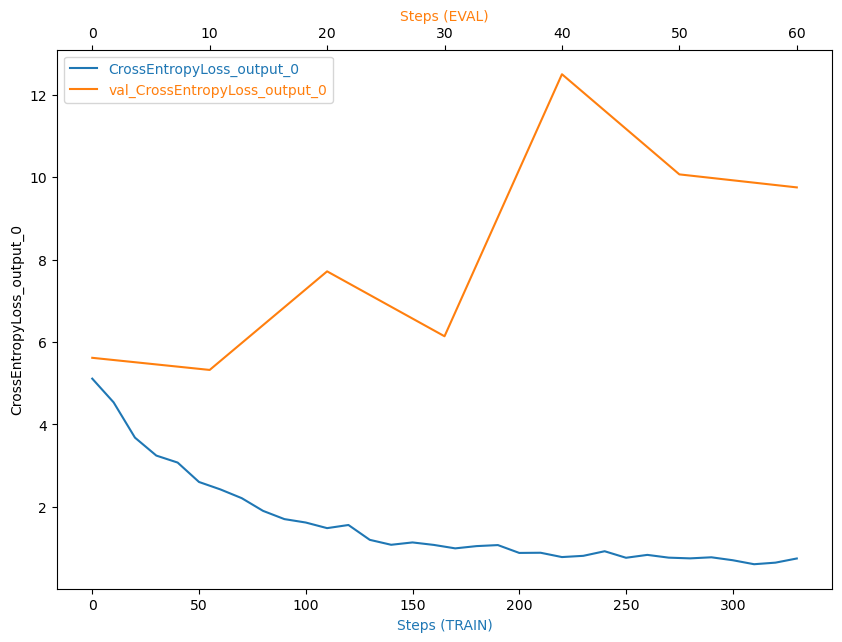

In [65]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [66]:
from jinja2.utils import markupsafe 
from markupsafe import Markup

In [67]:
! pip install jinja2==3.0

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [68]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2023-03-16 17:48:20.388 ip-172-16-106-174.ec2.internal:12858 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-706723451900/dog-Image-Classifier-2023-03-16-17-10-11-691/debug-output


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [69]:
# TODO: Display the profiler output
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-706723451900/', 'ProfilingIntervalInMilliseconds': 1000, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-706723451900/dog-Image-Classifier-2023-03-16-17-10-11-691/profiler-output


Profiler data from system is available


In [70]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)


[2023-03-16 17:48:24.179 ip-172-16-106-174.ec2.internal:12858 INFO metrics_reader_base.py:134] Getting 22 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [71]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-706723451900/dog-Image-Classifier-2023-03-16-17-10-11-691/rule-output


In [72]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2023-03-16 17:32:39     375421 dog-Image-Classifier-2023-03-16-17-10-11-691/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-16 17:32:39     223350 dog-Image-Classifier-2023-03-16-17-10-11-691/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-16 17:32:35        192 dog-Image-Classifier-2023-03-16-17-10-11-691/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-16 17:32:35        200 dog-Image-Classifier-2023-03-16-17-10-11-691/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-16 17:32:35       1941 dog-Image-Classifier-2023-03-16-17-10-11-691/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-16 17:32:35        127 dog-Image-Classifier-2023-03-16-17-10-11-691/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-16 17:32:35        199 dog-Image-Classifier-2023-03-16-17-10-11-691/rule-output/ProfilerReport

In [75]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:706723451900:processing-job/dog-image-classifier-2023--vanishinggradient-d328ed71',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2023, 3, 16, 17, 32, 50, 440000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:706723451900:processing-job/dog-image-classifier-2023--overfit-c2c012d6',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule Overfit at step 198 resulted in the condition being met\n',
  'LastModifiedTime': datetime.datetime(2023, 3, 16, 17, 32, 50, 440000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overtraining',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:706723451900:processing-job/dog-image-classifier-2023--overtraining-479041af',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': dat

In [79]:
 rules

[ProfilerRule(name='LowGPUUtilization', image_uri='503895931360.dkr.ecr.us-east-1.amazonaws.com/sagemaker-debugger-rules:latest', instance_type=None, container_local_output_path=None, s3_output_path=None, volume_size_in_gb=None, rule_parameters={'threshold_p95': '70', 'threshold_p5': '10', 'window': '500', 'patience': '1000', 'scan_interval_us': '60000000', 'rule_to_invoke': 'LowGPUUtilization'}),
 ProfilerRule(name='ProfilerReport', image_uri='503895931360.dkr.ecr.us-east-1.amazonaws.com/sagemaker-debugger-rules:latest', instance_type=None, container_local_output_path=None, s3_output_path=None, volume_size_in_gb=None, rule_parameters={'rule_to_invoke': 'ProfilerReport'}),
 Rule(name='VanishingGradient', image_uri='503895931360.dkr.ecr.us-east-1.amazonaws.com/sagemaker-debugger-rules:latest', instance_type=None, container_local_output_path=None, s3_output_path=None, volume_size_in_gb=None, rule_parameters={'rule_to_invoke': 'VanishingGradient'}),
 Rule(name='Overfit', image_uri='503895

In [80]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


In [81]:
profiler_report_name 

'ProfilerReport'

In [82]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [83]:
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [16]:
# loading the model manually from its location in S3
model_location = estimator.model_data

In [17]:
model_location

's3://sagemaker-us-east-1-706723451900/dog-Image-Classifier-2023-03-23-09-25-42-667/output/model.tar.gz'

In [59]:
role

'arn:aws:iam::706723451900:role/service-role/AmazonSageMaker-ExecutionRole-20230304T112891'

In [43]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, rule_configs, ProfilerRule
import matplotlib.pyplot as plt
import boto3
import smdebug
import os

from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [52]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "Dog-Images-Set"
role = sagemaker.get_execution_role()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [53]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [54]:
model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [55]:
# TODO: Deploy your model to an endpoint
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.large",  )
 # TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Creating model with name: dog-Image-Classifier-2023-03-23-12-27-35-951
INFO:sagemaker:Creating endpoint-config with name dog-Image-Classifier-2023-03-23-12-27-35-951
INFO:sagemaker:Creating endpoint with name dog-Image-Classifier-2023-03-23-12-27-35-951


-------!

In [56]:
import requests
#https://sagemaker-us-east-1-706723451900.s3.amazonaws.com/Dog-Images-Set/test/004.Akita/Akita_00244.jpg
request_dict={ "url": "https://sagemaker-us-east-1-706723451900.s3.amazonaws.com/Akita_00244+(1).jpg"}
img_byte = requests.get(request_dict['url']).content

In [57]:
type(img_byte)

bytes

In [70]:
# TODO: Run an prediction on the endpoint
import json
response = predictor.predict(img_byte, initial_args={"ContentType": "image/jpeg"})
print(response)

[[-5.876262664794922, -7.945693492889404, -7.899125099182129, 4.785614967346191, -9.34716796875, -7.559183120727539, -9.837433815002441, -7.633178234100342, -6.912012577056885, -9.335098266601562, -8.14130973815918, -6.355746746063232, -5.54944372177124, -8.28929328918457, -11.29911994934082, -8.414518356323242, -5.3681111335754395, -9.146519660949707, -9.774500846862793, -10.505655288696289, -6.219871520996094, -8.119227409362793, -9.120991706848145, -5.739152908325195, -10.01486873626709, -1.436987042427063, -10.930564880371094, -7.965036392211914, -5.29470682144165, -3.874913215637207, -9.761907577514648, -5.2805280685424805, -2.2604267597198486, -5.865331649780273, -6.668230056762695, -1.989173412322998, -7.4077043533325195, 0.9870749711990356, -7.74799919128418, -5.110034465789795, -5.647317409515381, -0.16268156468868256, -9.560400009155273, -6.230180263519287, -8.458740234375, -4.624056816101074, -10.958589553833008, -5.384210109710693, -4.4350385665893555, -7.605826377868652, -

In [74]:
max(response)

[-5.876262664794922,
 -7.945693492889404,
 -7.899125099182129,
 4.785614967346191,
 -9.34716796875,
 -7.559183120727539,
 -9.837433815002441,
 -7.633178234100342,
 -6.912012577056885,
 -9.335098266601562,
 -8.14130973815918,
 -6.355746746063232,
 -5.54944372177124,
 -8.28929328918457,
 -11.29911994934082,
 -8.414518356323242,
 -5.3681111335754395,
 -9.146519660949707,
 -9.774500846862793,
 -10.505655288696289,
 -6.219871520996094,
 -8.119227409362793,
 -9.120991706848145,
 -5.739152908325195,
 -10.01486873626709,
 -1.436987042427063,
 -10.930564880371094,
 -7.965036392211914,
 -5.29470682144165,
 -3.874913215637207,
 -9.761907577514648,
 -5.2805280685424805,
 -2.2604267597198486,
 -5.865331649780273,
 -6.668230056762695,
 -1.989173412322998,
 -7.4077043533325195,
 0.9870749711990356,
 -7.74799919128418,
 -5.110034465789795,
 -5.647317409515381,
 -0.16268156468868256,
 -9.560400009155273,
 -6.230180263519287,
 -8.458740234375,
 -4.624056816101074,
 -10.958589553833008,
 -5.3842101097106

In [76]:
(response[0].index(max(response[0])) +1)

4

In [77]:
import numpy as np
import cv2
image = np.asarray(bytearray(img_byte), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)

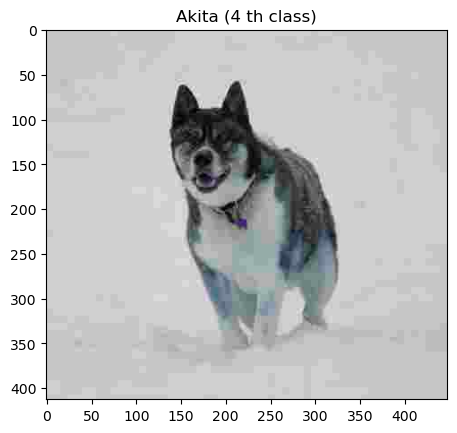

In [78]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title('Akita (4 th class)');

In [79]:
img = {'image': image}

In [80]:
type(image)

numpy.ndarray

In [82]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
#predictor.delete_endpoint()